## Lab3 Part 2

Lab3 is splitted into two parts as it is gettign really long.
## Task 5.1 Dynamic Programming
The goal of this second half of the lab is to investigate dynamic progamming along scanlines in stereo vision.  In this part of the practical, we build a basic dynamic programming algorithm, which will solve the same problem as presented in the notes.  

In Task5 we will apply this to the stereo problem.  

Use the template below, filling in parts marked "TO DO" (only todo for Task 5.1 one is in functions.py).



Loss = 17.4

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from functions import dynamicProgram, dynamicProgramVec
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# define unary costs : unaryCosts[d,j] represents the cost for having
# disparity d at pixel j.
unaryCosts = np.array([[2.0, 1.1, 5.7, 1.5, 6.0, 3.1],
              [0.8, 4.8, 1.0, 3.0, 6.9, 3.3],
              [4.3, 2.3, 2.4, 2.4, 6.6, 6.2],
              [6.4, 0.0, 6.1, 0.8, 7.1, 2.1],
              [2.3, 2.2, 4.9, 8.9, 1.0, 9.8]])

# define pairwise costs:  pairwiseCosts[a,b] represents the cost for changing from 
# disparity level A at pixel j to disparity level B at pixel j+1;
pairwiseCosts = np.array([[   0,   2, 100, 100, 100],
                          [   2,   0,   2, 100, 100],
                          [ 100,   2,   0,   2, 100],
                          [ 100, 100,   2,   0,   2],
                          [ 100, 100, 100,   2,   0]])



In [3]:
# TODO Fill in the dynamicProgram function in "functions.py"

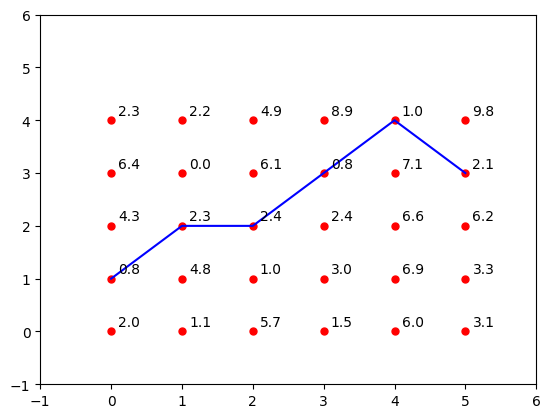

Path Cost = 17.4


In [18]:
# Now, use dynamic programming to find best solution.
bestPath = dynamicProgramVec(unaryCosts,pairwiseCosts)

# display the nodes
nY = len(unaryCosts)
nX = len(unaryCosts[0])
plt.axis([-1, 6, -1, 6])
for cY in range(nY):
    for cX in range(nX):
        plt.plot(cX,cY,'ro',ms=5.)
        plt.text(cX+.1, cY+.1, unaryCosts[cY,cX])


# display the best path
plt.plot(range(nX),bestPath,'b-')
plt.show()

# calculate the cost of the path computed
bestPathCostUnary = np.sum((np.transpose(unaryCosts).reshape((nX*nY,1)))[(np.add(nY * np.array(range(nX)),np.transpose(bestPath)[0])).astype(int)])
bestPathCostPairwise = np.sum(np.transpose(pairwiseCosts).reshape((nY*nY,1))[np.array([bestPath[0:-1]+nY*bestPath[1:]]).reshape((1,nY)).astype(int)[0]])
bestCost = bestPathCostUnary+bestPathCostPairwise
print('Path Cost =',bestCost)

## Task 5.2 Dynamic Programming for stereo depth estimation


The goal of this part of the practical is to use the dynamic programming routine that you developed in the first part to solve the dense stero problem.

Use the template below, filling in parts marked "TO DO".

### Extra Tasks:
Task hint: Crop or downsample your image if your stereo is slow

Task1: Capture or find two image pairs: one with good stereo depth and one with bad stereo depth. Note that you should only the two camera have a known, and there should be no moving objects in the scene.

Task2: Measure your baseline distance between the camera with a ruler, does the depth esimation match the real distance？

Task3: (Unmarked Optional) Can you use two cameras at the same time for stereo capture?

In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from functions import dynamicProgram, dynamicProgramVec
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# load in images and ground truth
data = loadmat('../dataset/StereoData.mat')
im1 = data['im1'].astype('int')
im2 = data['im2'].astype('int')
gt = data['gt'].astype('int')

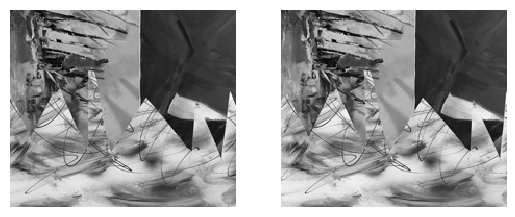

In [22]:
# ground truth disparity is originally expressed in 16'ths of pixels but we 
# will only consider whole-pixel shifts
gtDisp = np.round(gt.astype(float)/16)

im1show = im1
im2show = im2
if np.max(im1) > 1:
    im1show = im1.astype(float)/255.
    im2show = im2.astype(float)/255.
    
# display image
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax2.imshow(im2, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')
plt.show()

### Complete the TODOs in the final cell below

Here we are going to make use of the "dynamicProgram" function we just wrote.

We will first calculate the unary costs before using our function to calculate estimated disparity.

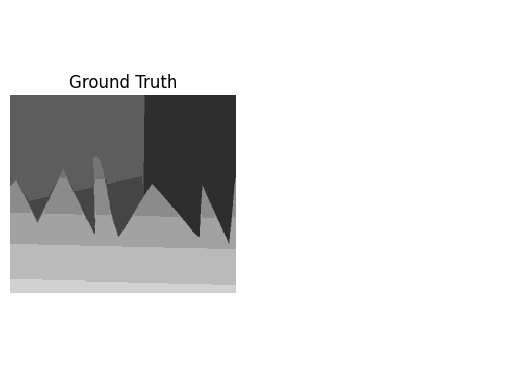

Procesing scanline  0


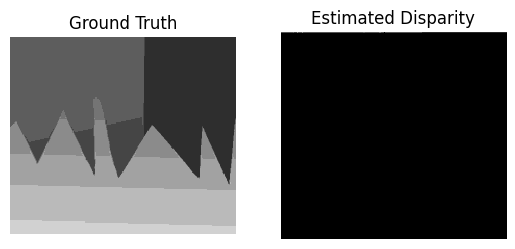

Procesing scanline  1


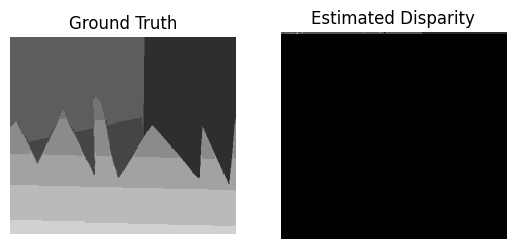

Procesing scanline  2


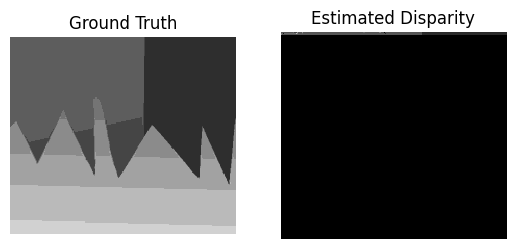

Procesing scanline  3


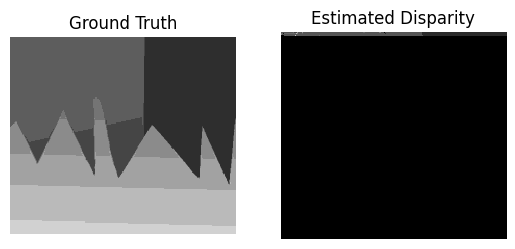

Procesing scanline  4


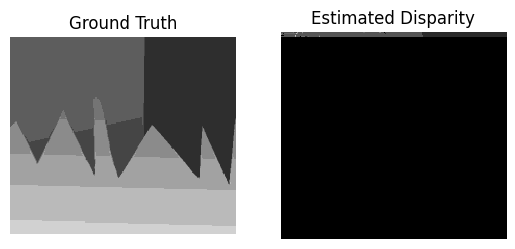

Procesing scanline  5


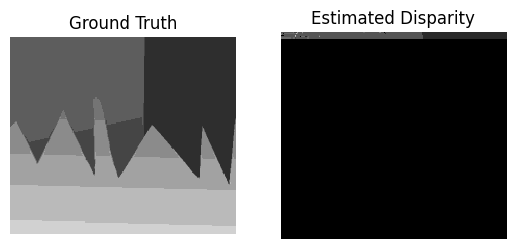

Procesing scanline  6


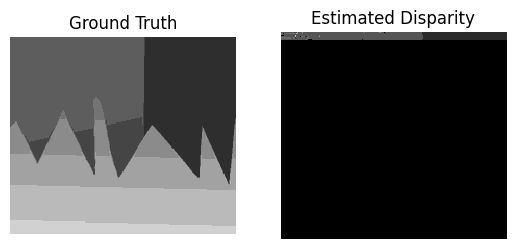

Procesing scanline  7


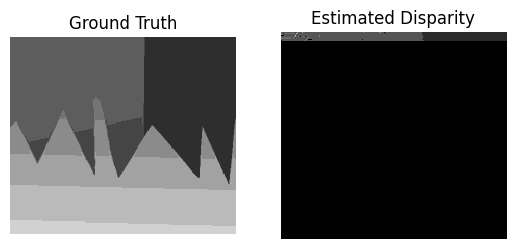

Procesing scanline  8


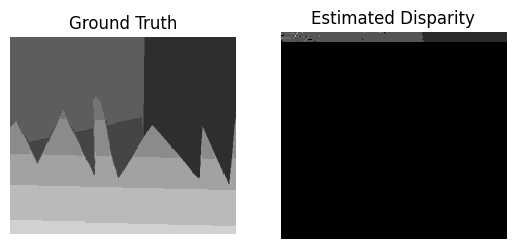

Procesing scanline  9


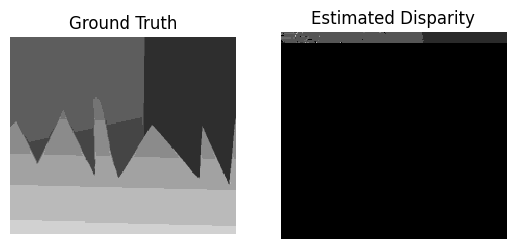

Procesing scanline  10


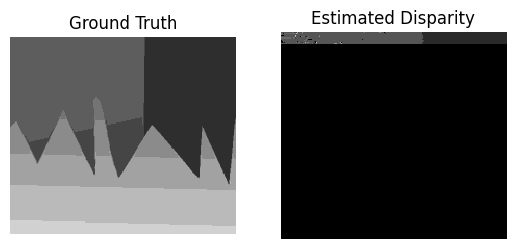

Procesing scanline  11


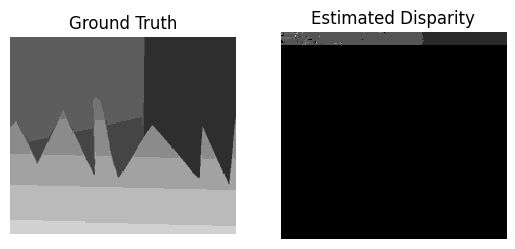

Procesing scanline  12


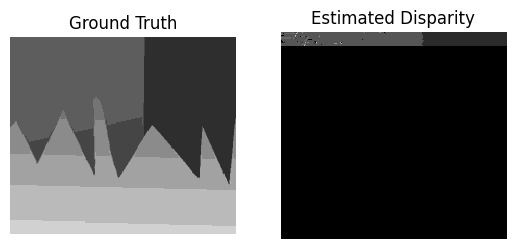

Procesing scanline  13


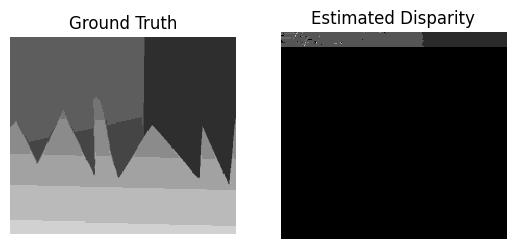

Procesing scanline  14


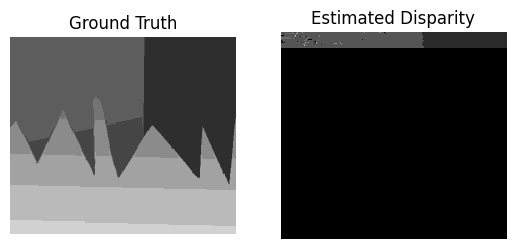

Procesing scanline  15


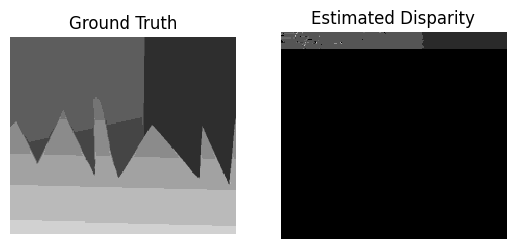

Procesing scanline  16


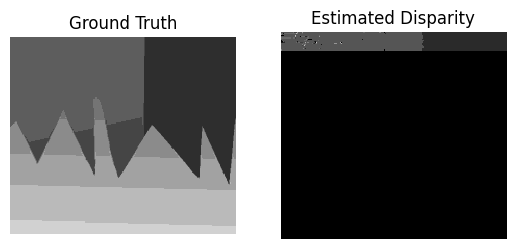

Procesing scanline  17


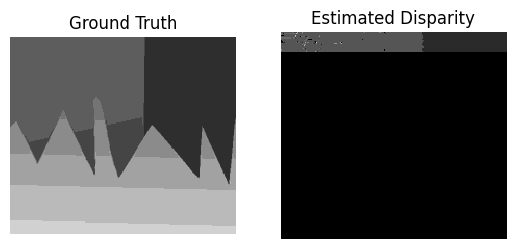

Procesing scanline  18


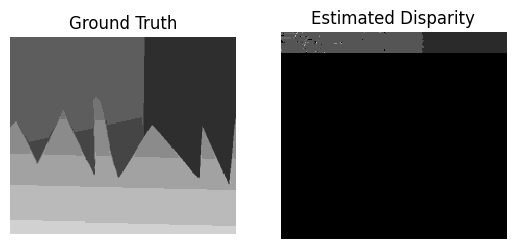

Procesing scanline  19


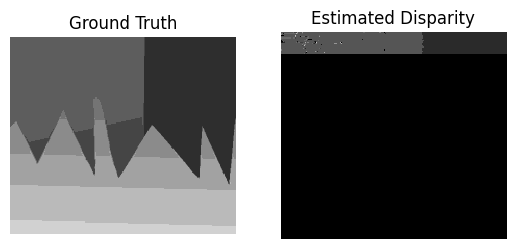

Procesing scanline  20


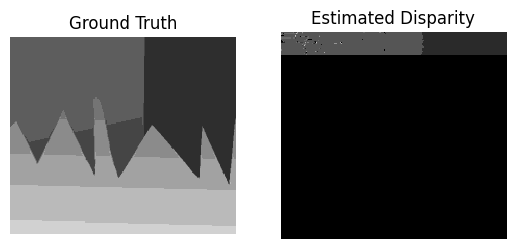

Procesing scanline  21


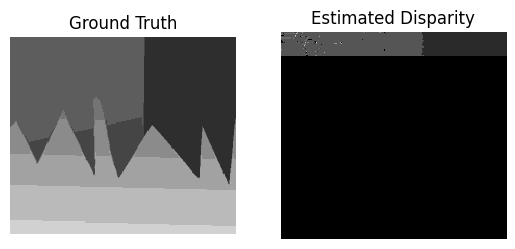

Procesing scanline  22


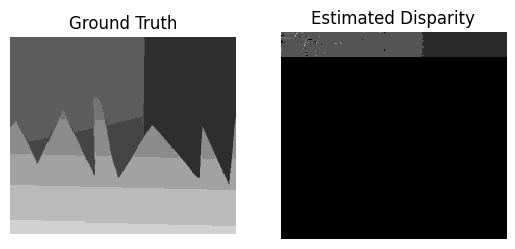

Procesing scanline  23


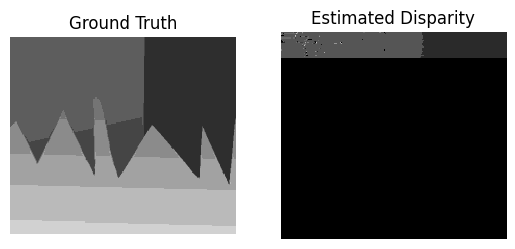

Procesing scanline  24


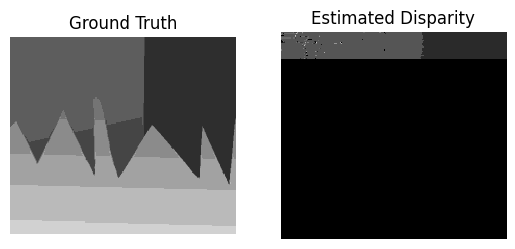

Procesing scanline  25


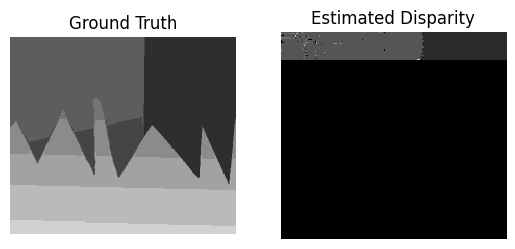

Procesing scanline  26


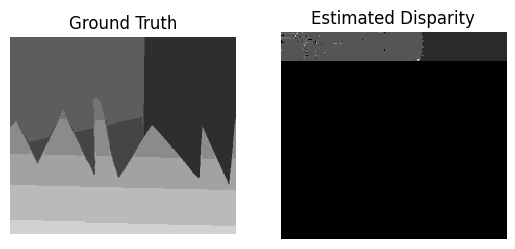

Procesing scanline  27


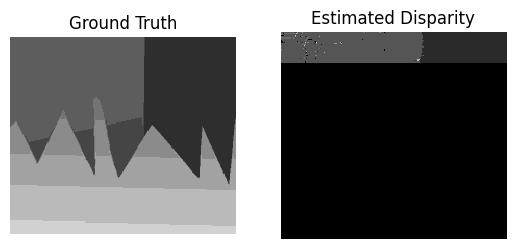

Procesing scanline  28


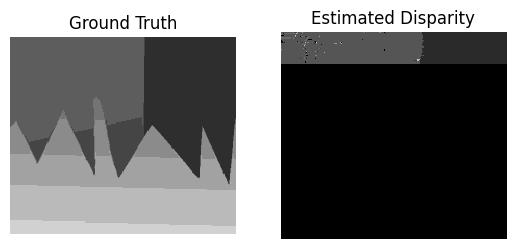

Procesing scanline  29


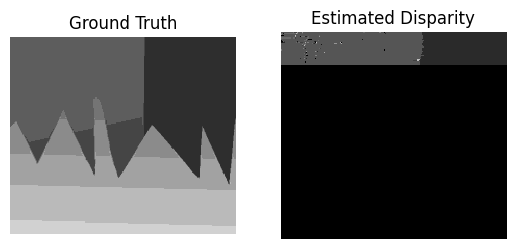

Procesing scanline  30


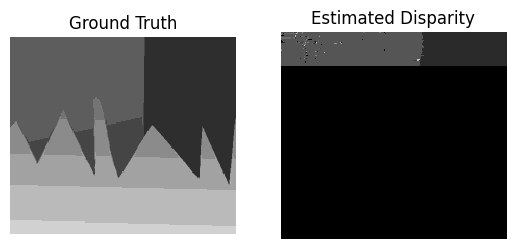

Procesing scanline  31


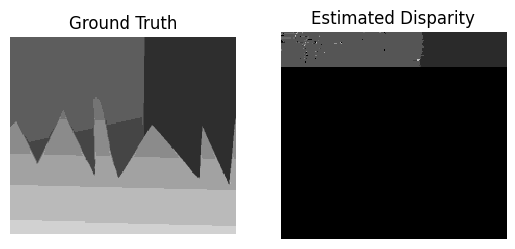

Procesing scanline  32


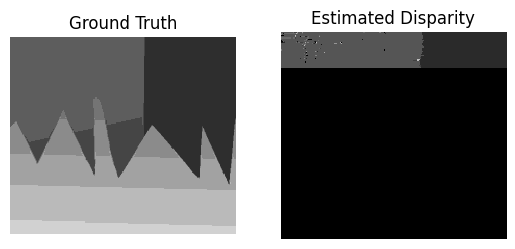

Procesing scanline  33


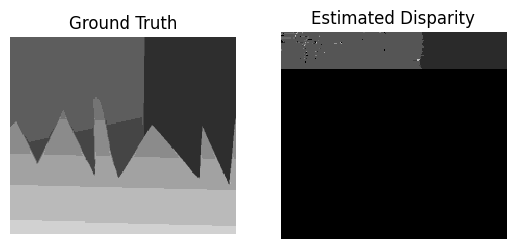

Procesing scanline  34


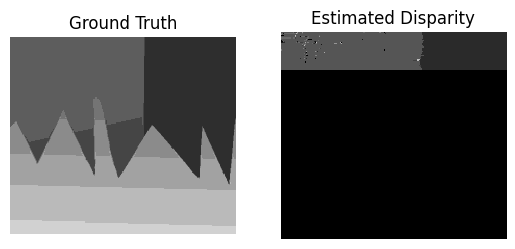

Procesing scanline  35


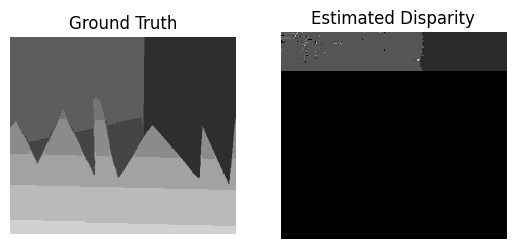

Procesing scanline  36


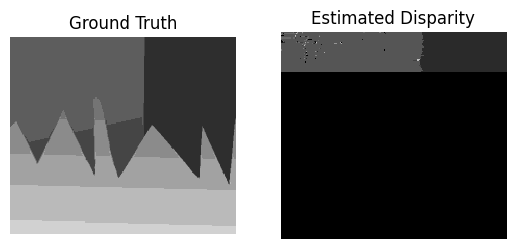

Procesing scanline  37


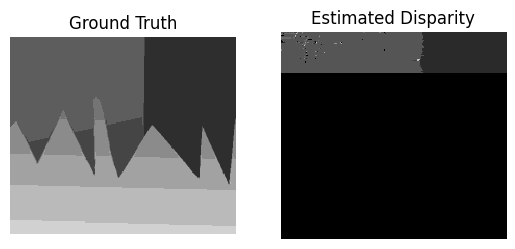

Procesing scanline  38


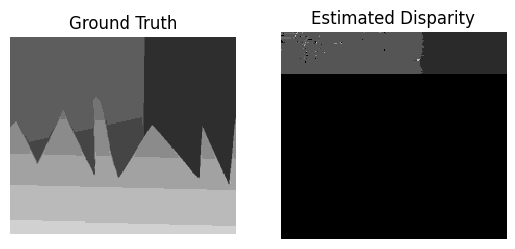

Procesing scanline  39


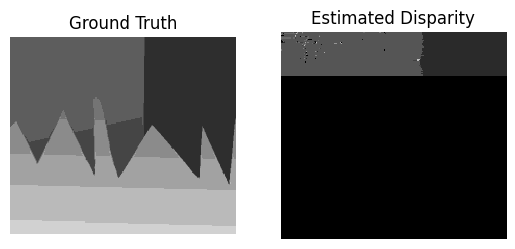

Procesing scanline  40


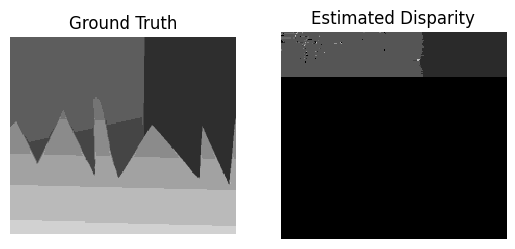

Procesing scanline  41


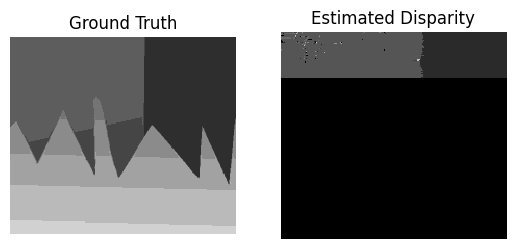

Procesing scanline  42


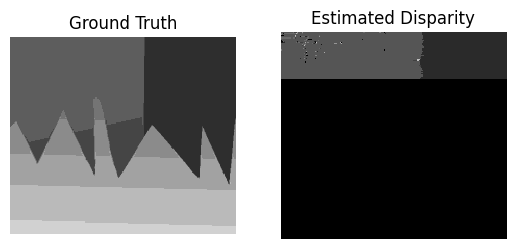

Procesing scanline  43


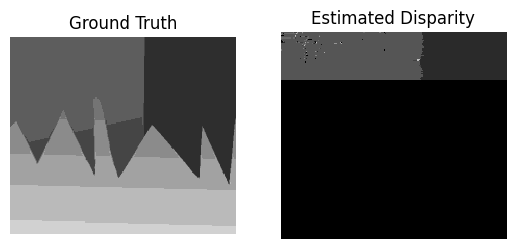

Procesing scanline  44


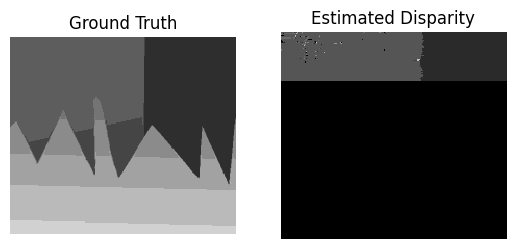

Procesing scanline  45


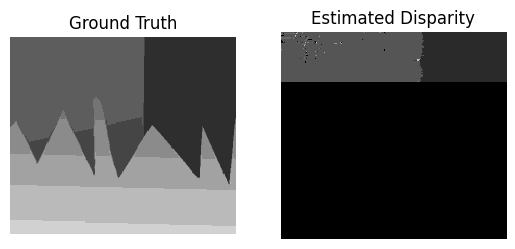

Procesing scanline  46


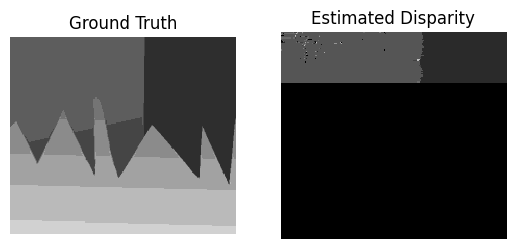

Procesing scanline  47


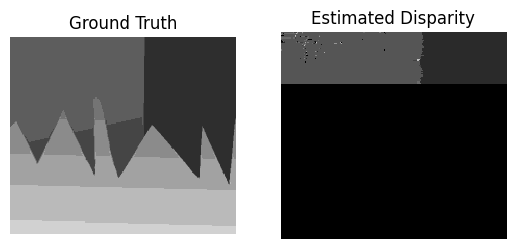

Procesing scanline  48


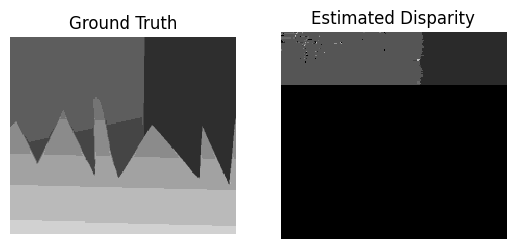

Procesing scanline  49


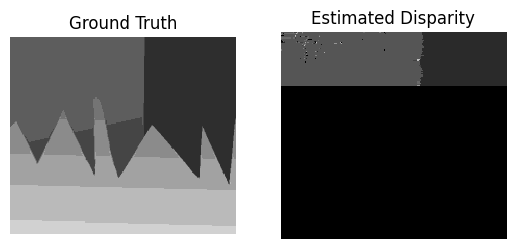

Procesing scanline  50


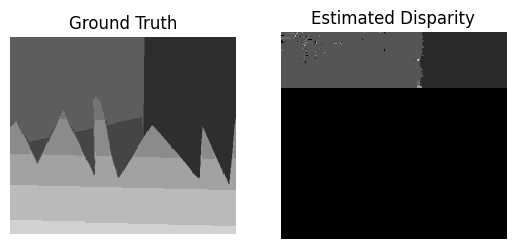

Procesing scanline  51


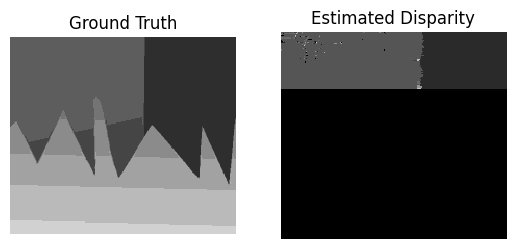

Procesing scanline  52


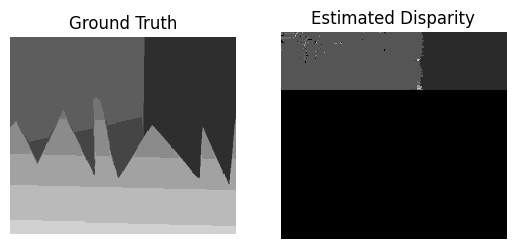

Procesing scanline  53


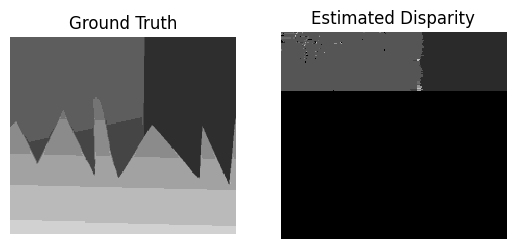

Procesing scanline  54


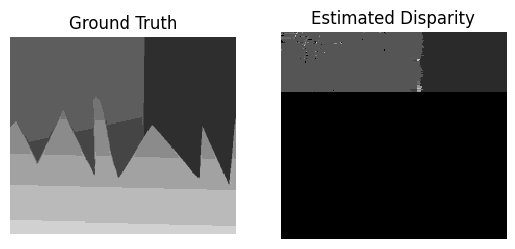

Procesing scanline  55


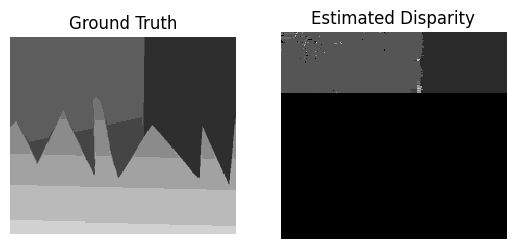

Procesing scanline  56


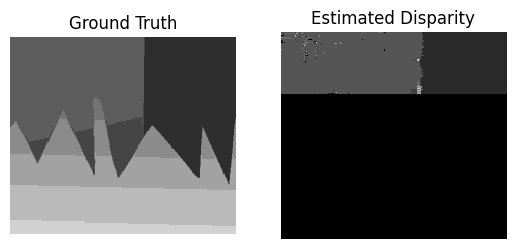

Procesing scanline  57


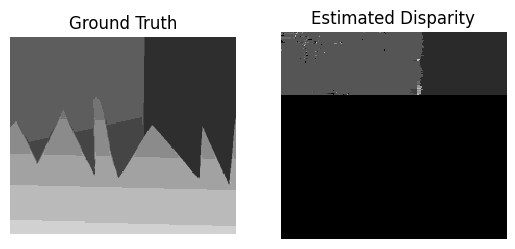

Procesing scanline  58


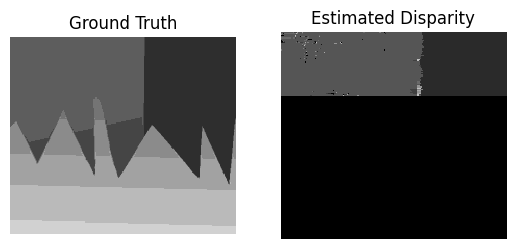

Procesing scanline  59


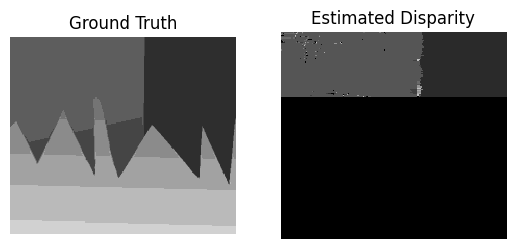

Procesing scanline  60


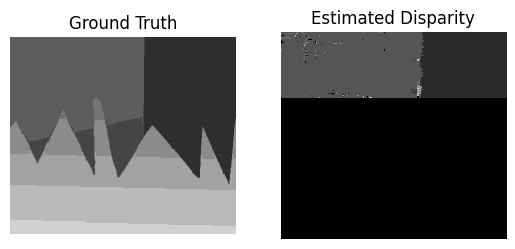

Procesing scanline  61


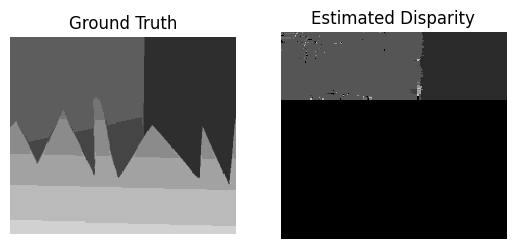

Procesing scanline  62


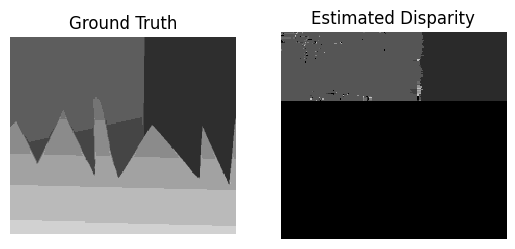

Procesing scanline  63


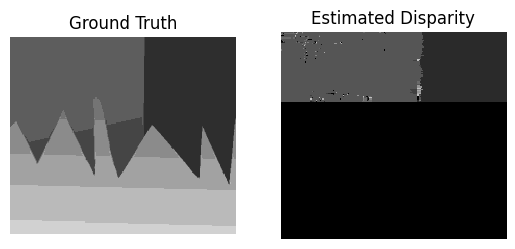

Procesing scanline  64


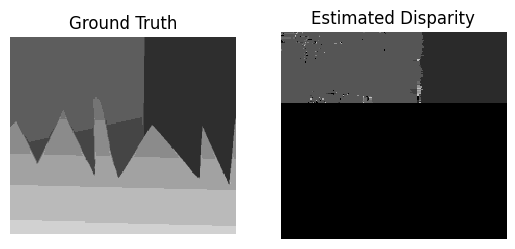

Procesing scanline  65


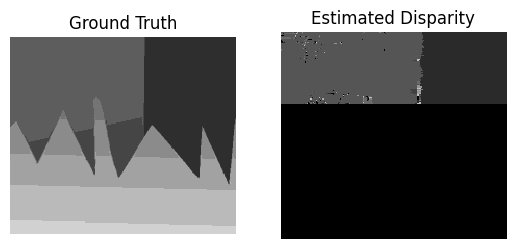

Procesing scanline  66


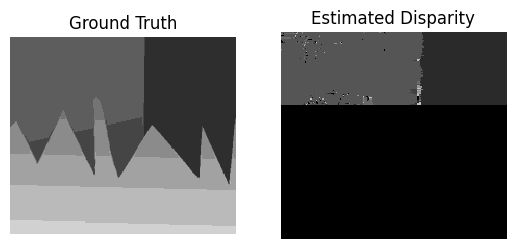

Procesing scanline  67


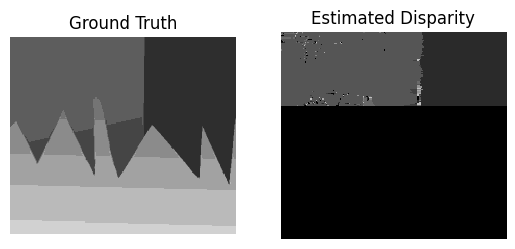

Procesing scanline  68


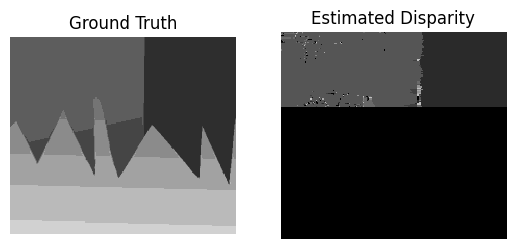

Procesing scanline  69


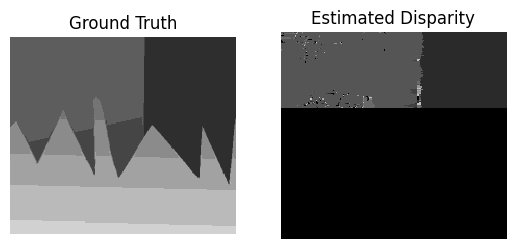

Procesing scanline  70


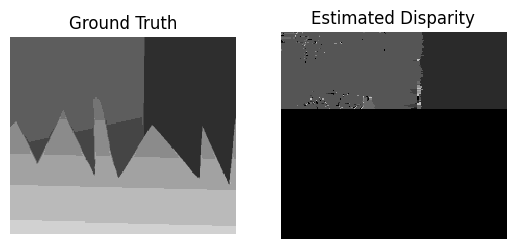

Procesing scanline  71


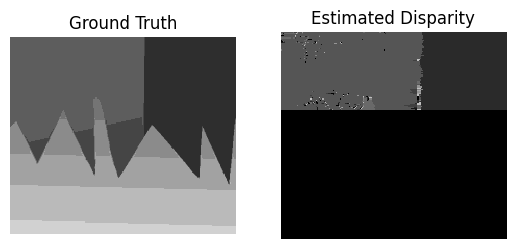

Procesing scanline  72


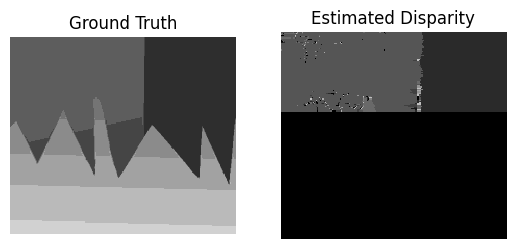

Procesing scanline  73


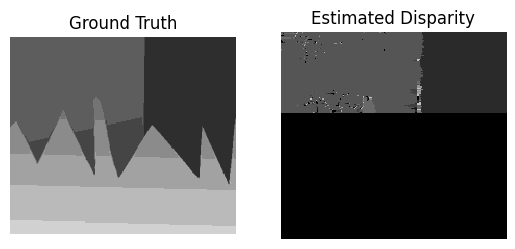

Procesing scanline  74


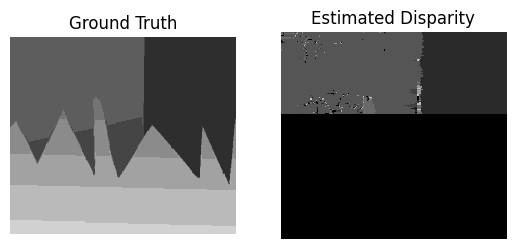

Procesing scanline  75


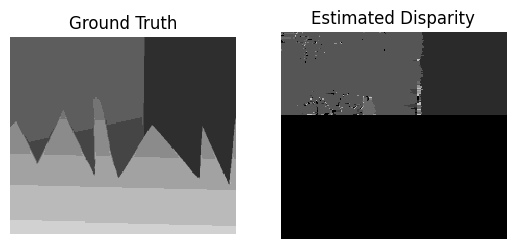

Procesing scanline  76


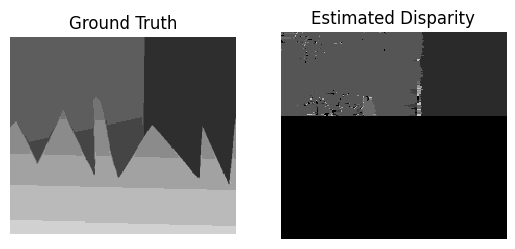

Procesing scanline  77


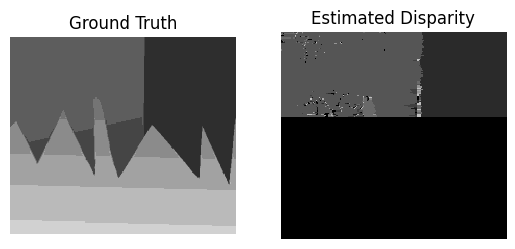

Procesing scanline  78


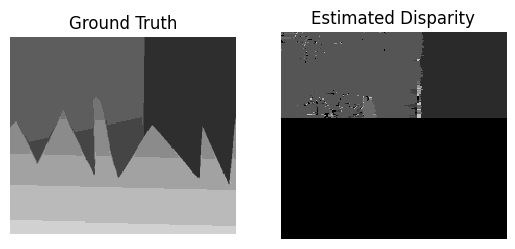

Procesing scanline  79


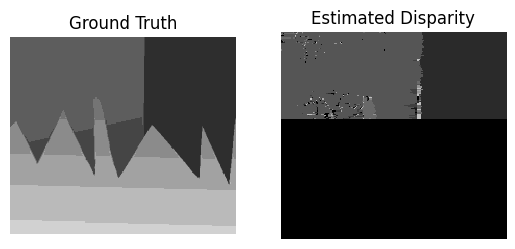

Procesing scanline  80


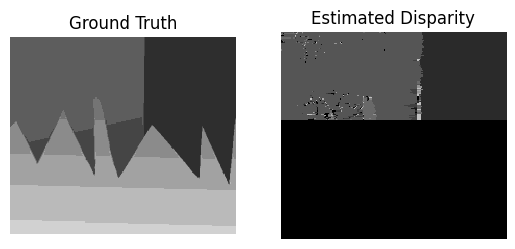

Procesing scanline  81


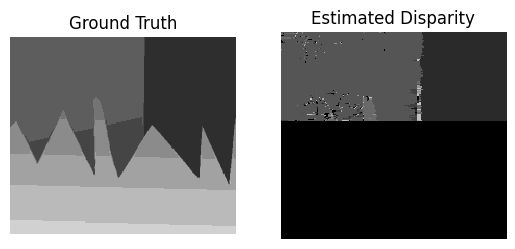

Procesing scanline  82


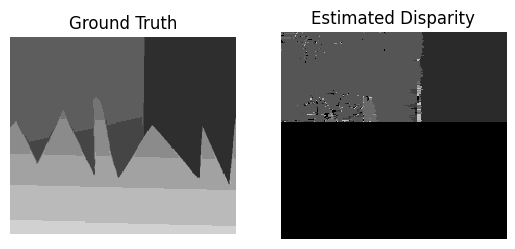

Procesing scanline  83


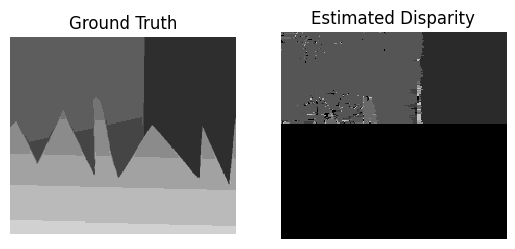

Procesing scanline  84


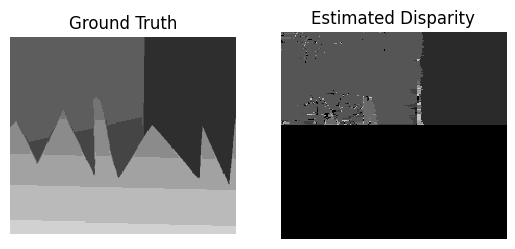

Procesing scanline  85


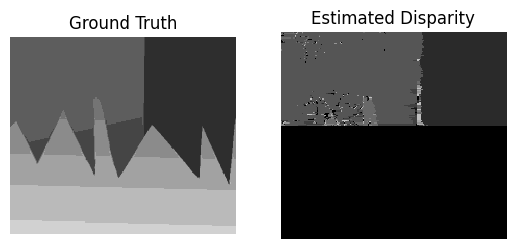

Procesing scanline  86


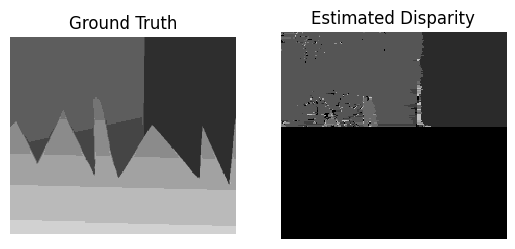

Procesing scanline  87


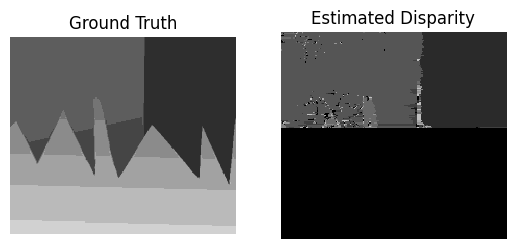

Procesing scanline  88


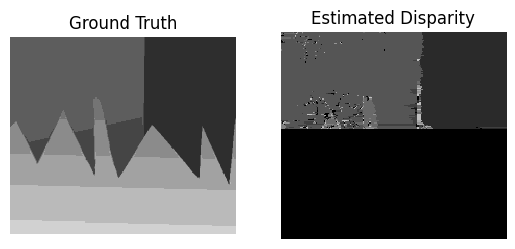

Procesing scanline  89


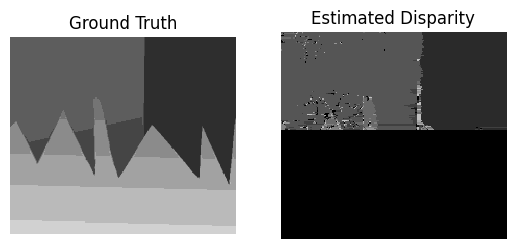

Procesing scanline  90


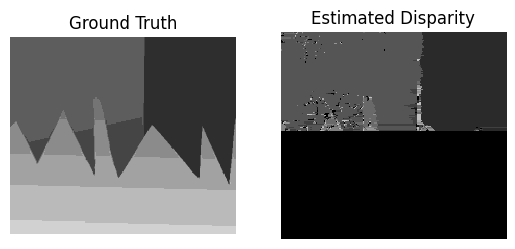

Procesing scanline  91


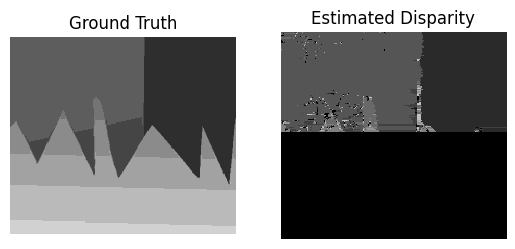

Procesing scanline  92


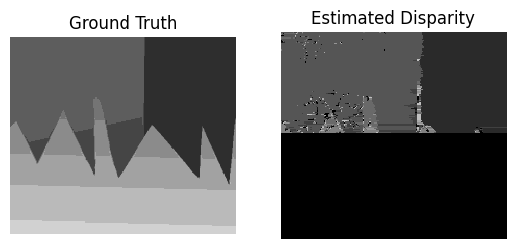

Procesing scanline  93


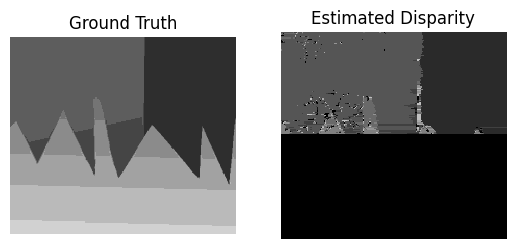

Procesing scanline  94


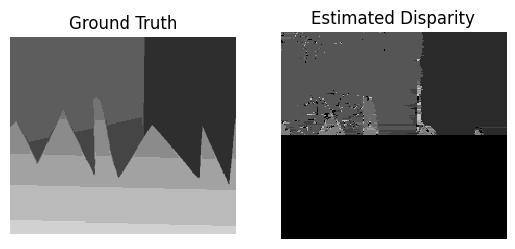

Procesing scanline  95


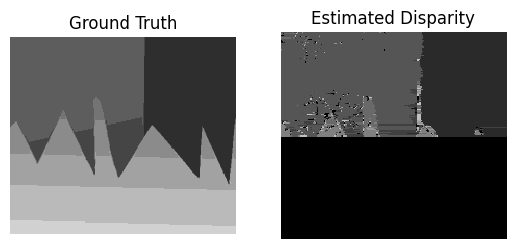

Procesing scanline  96


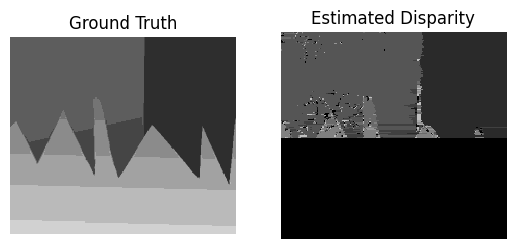

Procesing scanline  97


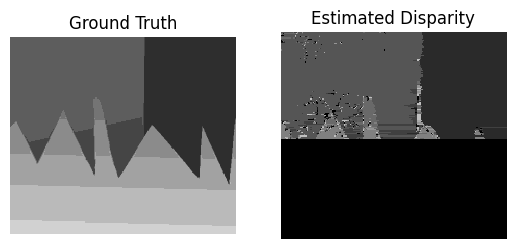

Procesing scanline  98


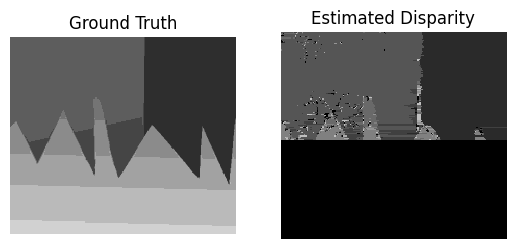

Procesing scanline  99


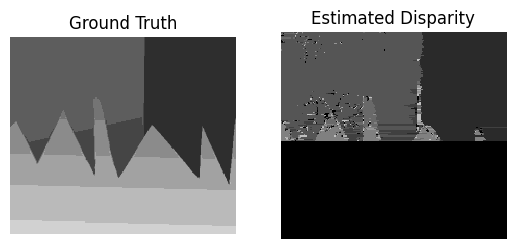

Procesing scanline  100


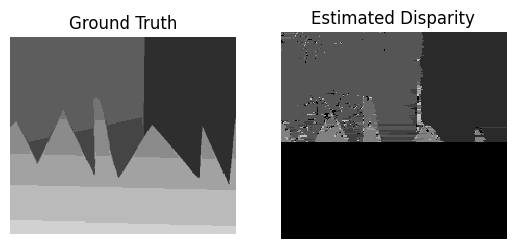

Procesing scanline  101


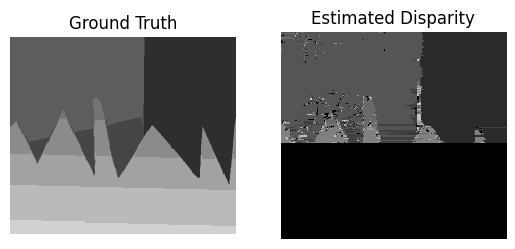

Procesing scanline  102


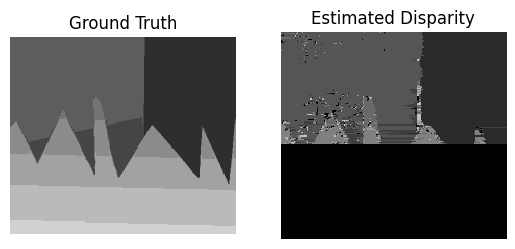

Procesing scanline  103


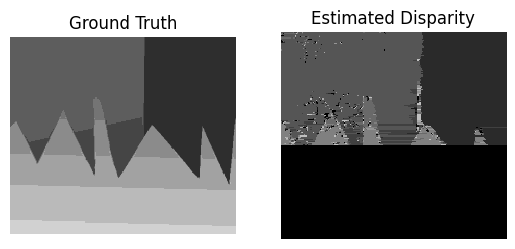

Procesing scanline  104


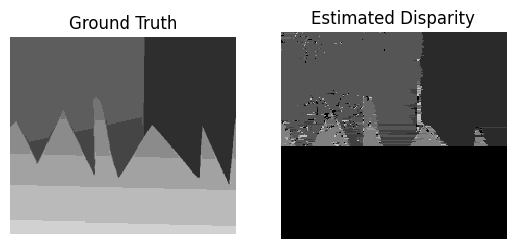

Procesing scanline  105


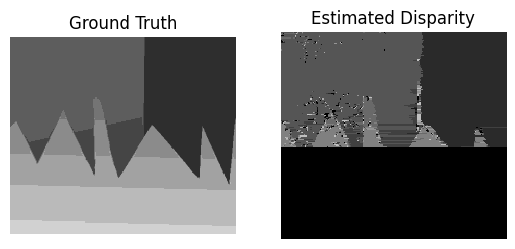

Procesing scanline  106


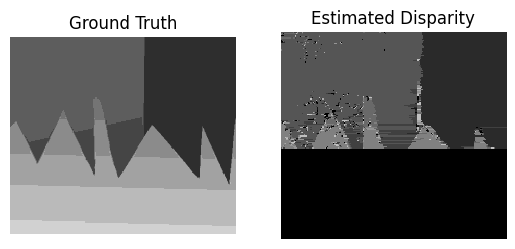

Procesing scanline  107


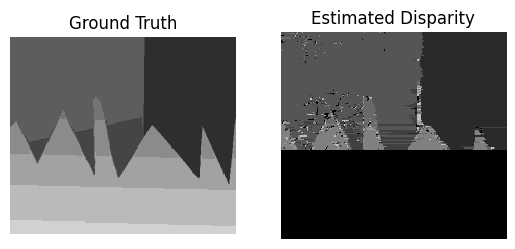

Procesing scanline  108


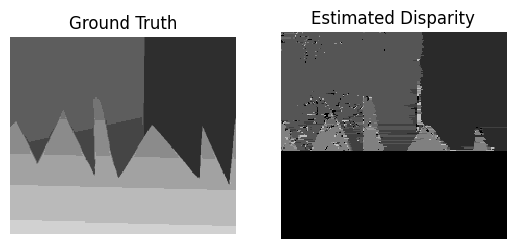

Procesing scanline  109


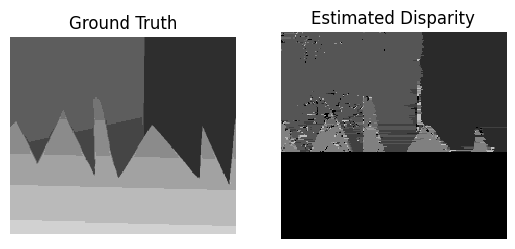

Procesing scanline  110


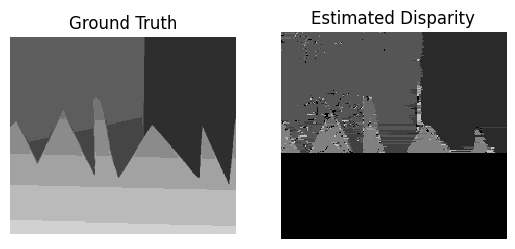

Procesing scanline  111


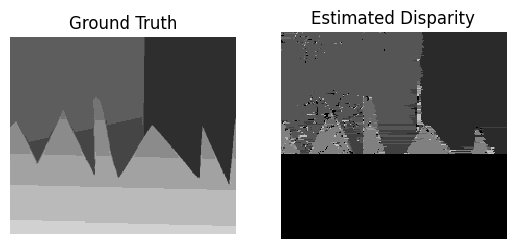

Procesing scanline  112


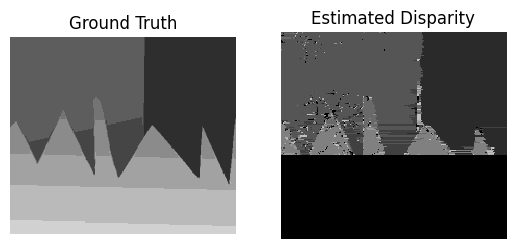

Procesing scanline  113


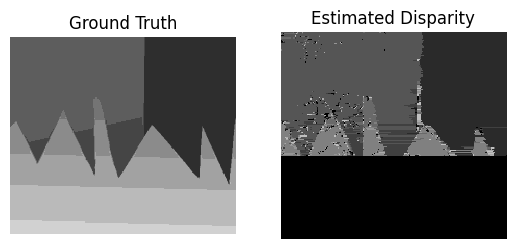

Procesing scanline  114


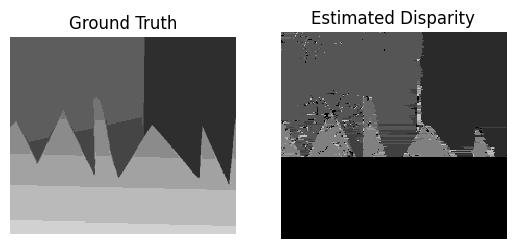

Procesing scanline  115


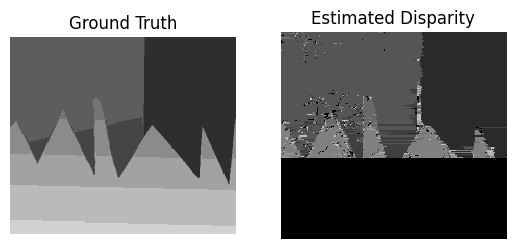

Procesing scanline  116


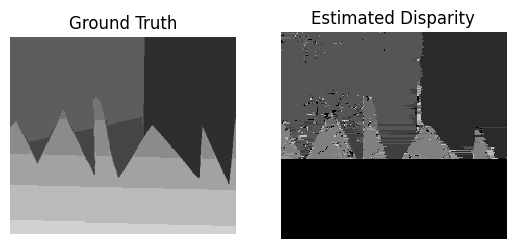

Procesing scanline  117


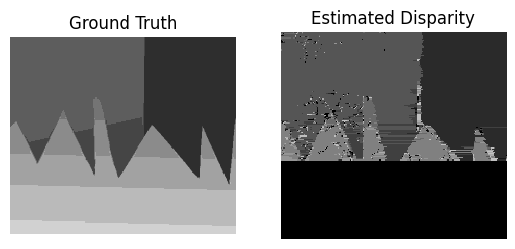

Procesing scanline  118


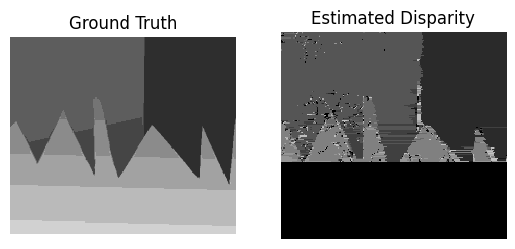

Procesing scanline  119


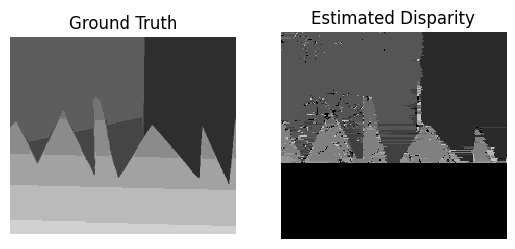

Procesing scanline  120


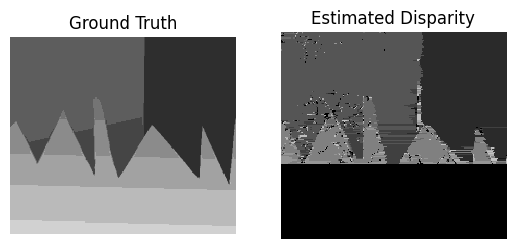

Procesing scanline  121


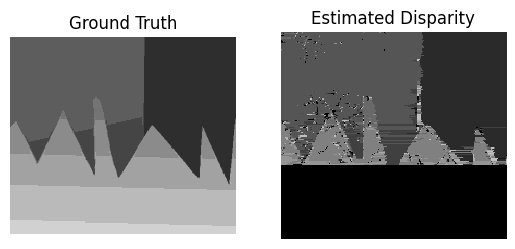

Procesing scanline  122


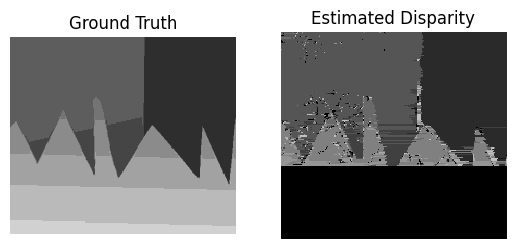

Procesing scanline  123


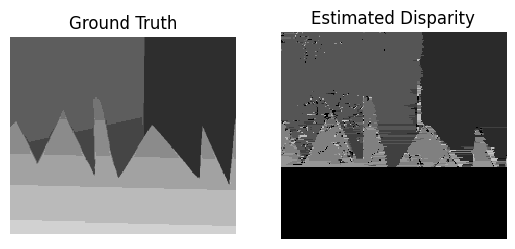

Procesing scanline  124


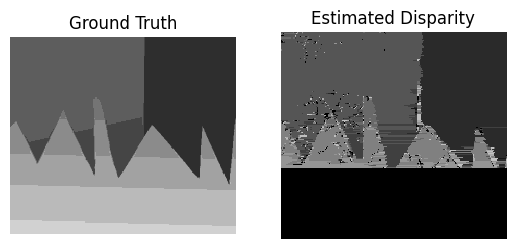

Procesing scanline  125


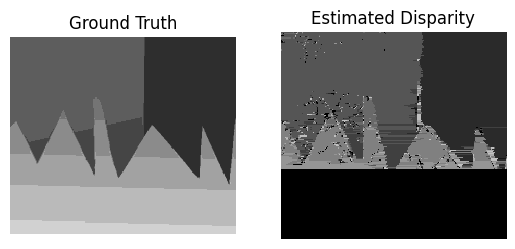

Procesing scanline  126


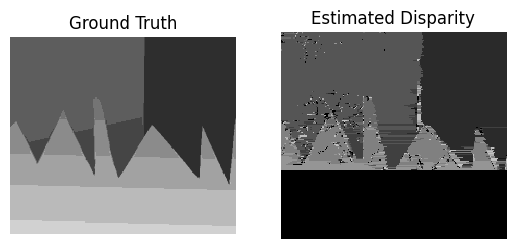

Procesing scanline  127


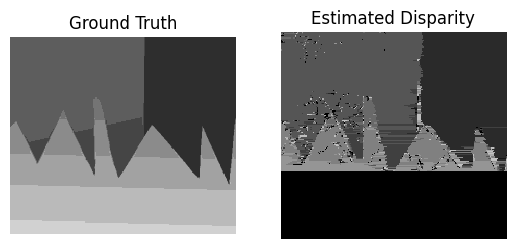

Procesing scanline  128


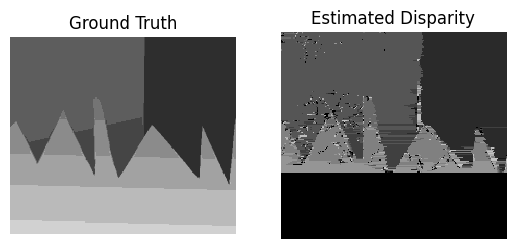

Procesing scanline  129


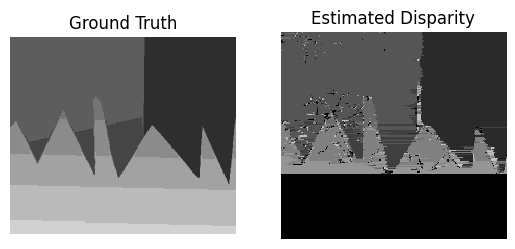

Procesing scanline  130


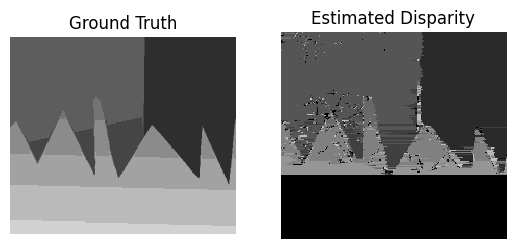

Procesing scanline  131


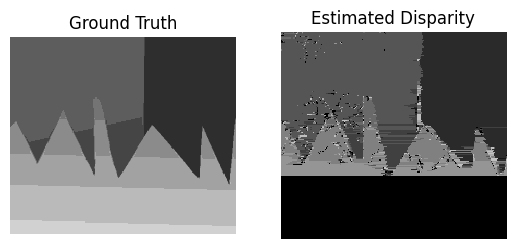

Procesing scanline  132


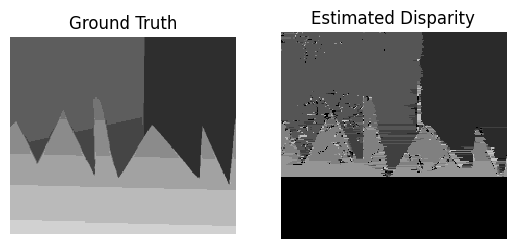

Procesing scanline  133


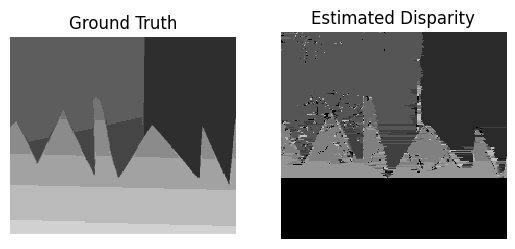

Procesing scanline  134


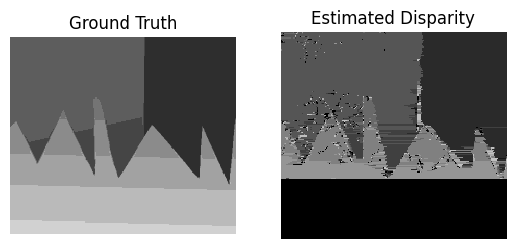

Procesing scanline  135


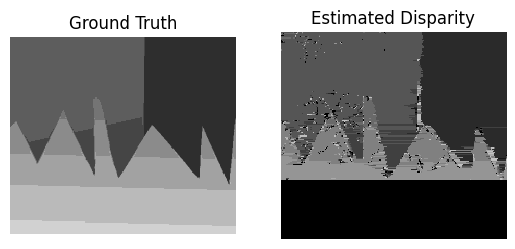

Procesing scanline  136


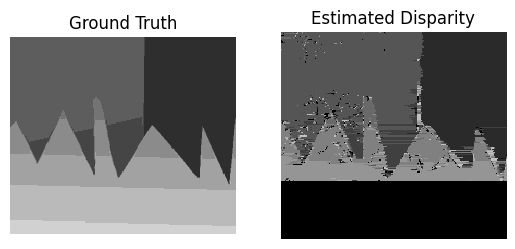

Procesing scanline  137


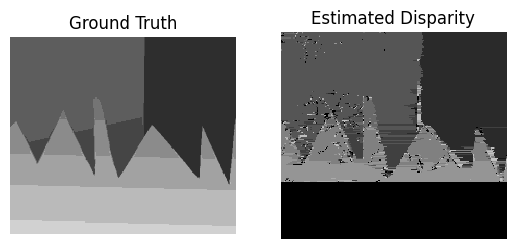

Procesing scanline  138


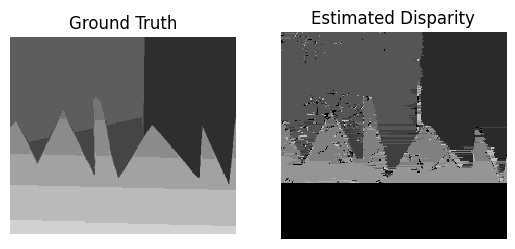

Procesing scanline  139


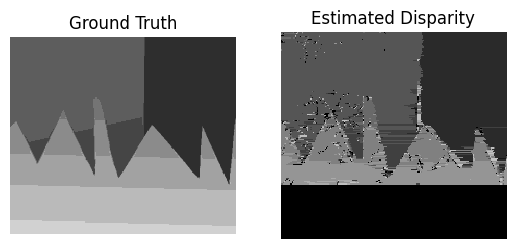

Procesing scanline  140


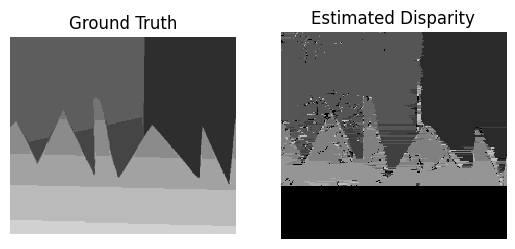

Procesing scanline  141


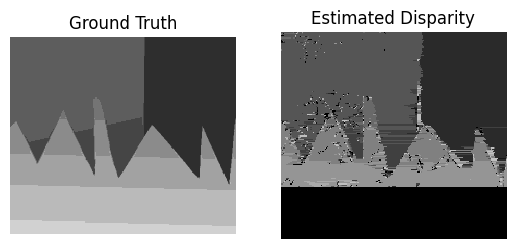

Procesing scanline  142


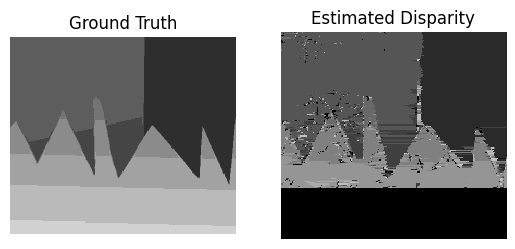

Procesing scanline  143


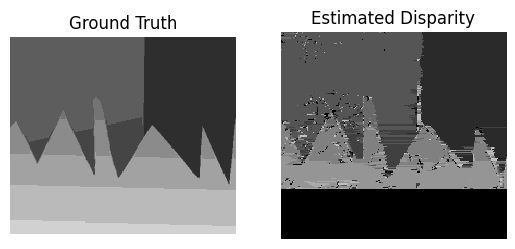

Procesing scanline  144


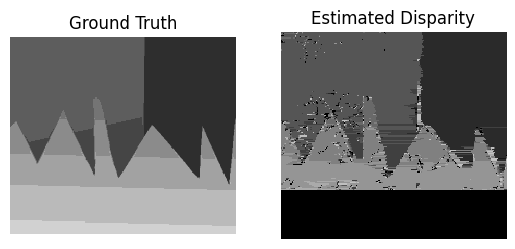

Procesing scanline  145


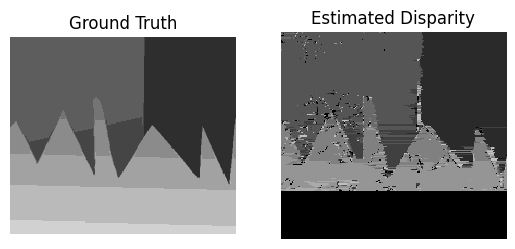

Procesing scanline  146


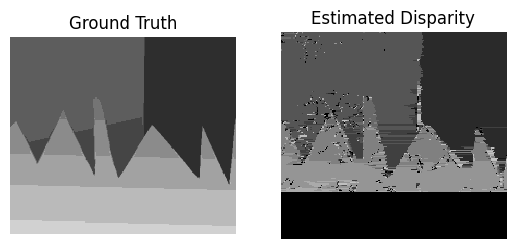

Procesing scanline  147


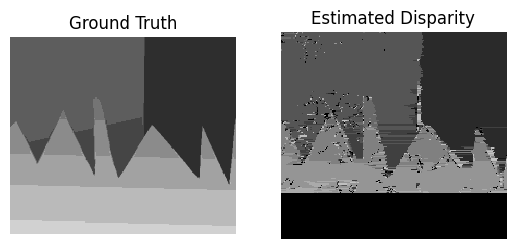

Procesing scanline  148


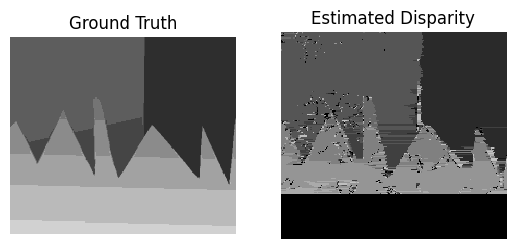

Procesing scanline  149


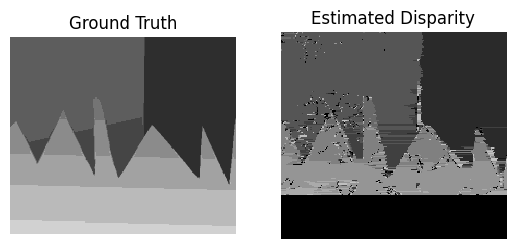

Procesing scanline  150


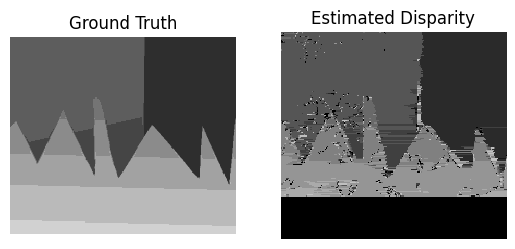

Procesing scanline  151


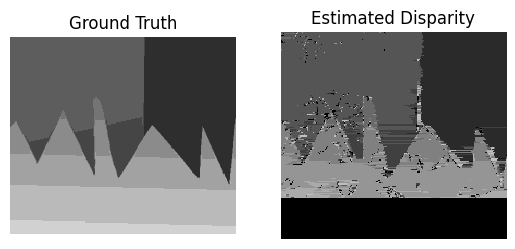

Procesing scanline  152


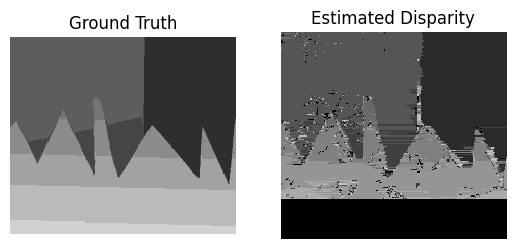

Procesing scanline  153


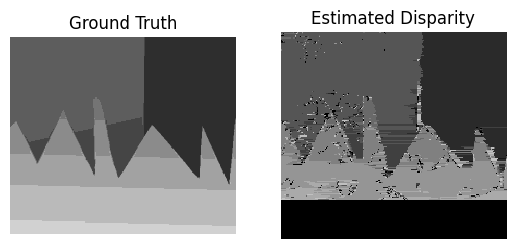

Procesing scanline  154


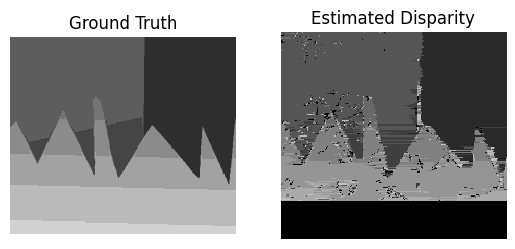

Procesing scanline  155


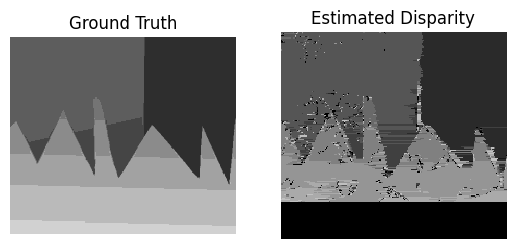

Procesing scanline  156


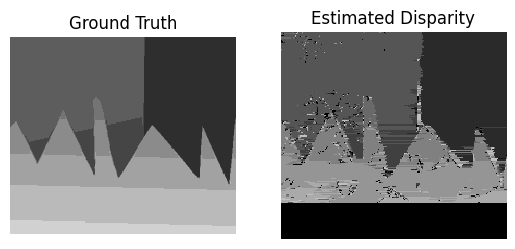

Procesing scanline  157


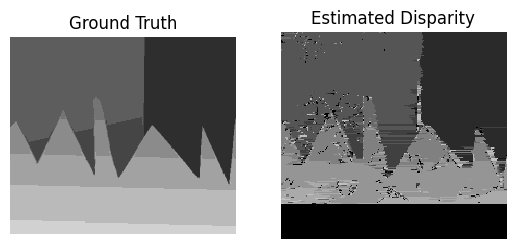

Procesing scanline  158


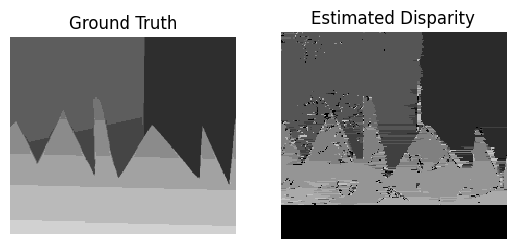

Procesing scanline  159


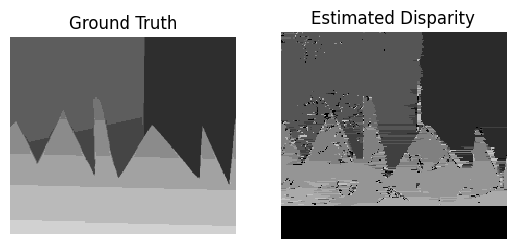

Procesing scanline  160


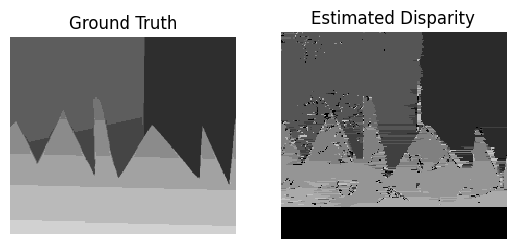

Procesing scanline  161


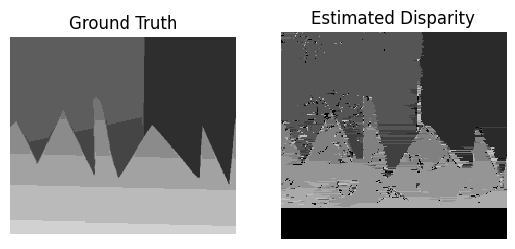

Procesing scanline  162


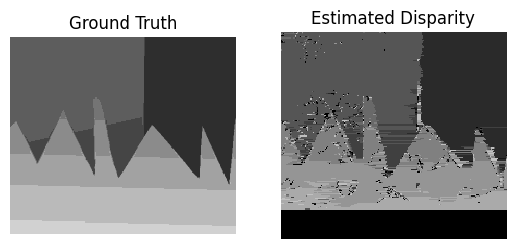

Procesing scanline  163


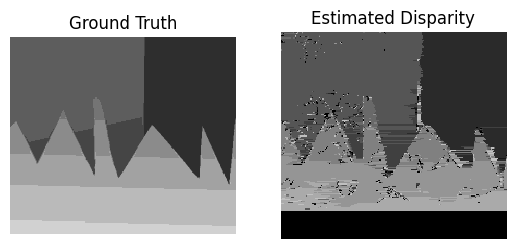

Procesing scanline  164


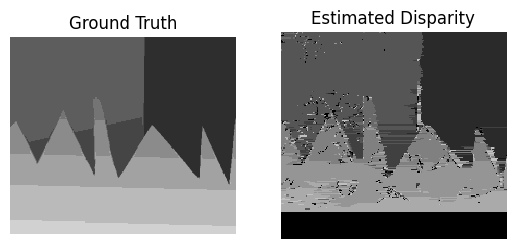

Procesing scanline  165


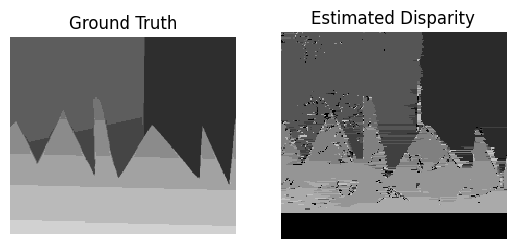

Procesing scanline  166


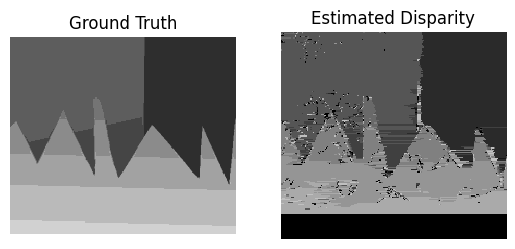

Procesing scanline  167


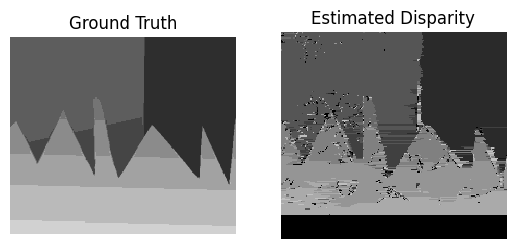

Procesing scanline  168


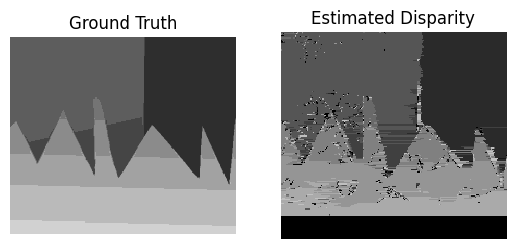

Procesing scanline  169


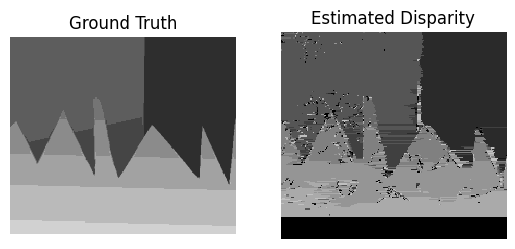

Procesing scanline  170


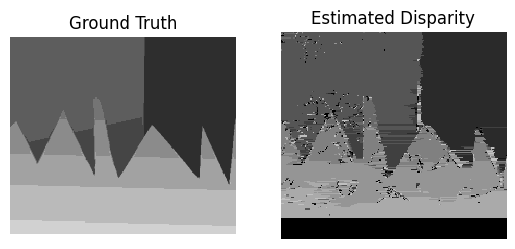

Procesing scanline  171


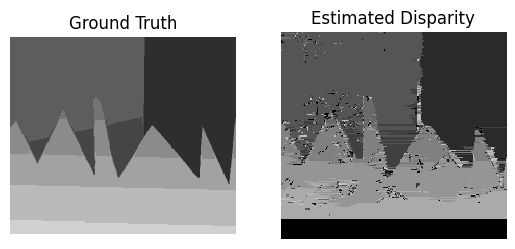

Procesing scanline  172


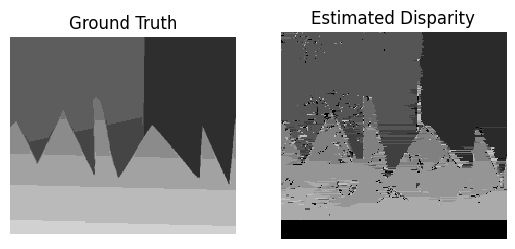

Procesing scanline  173


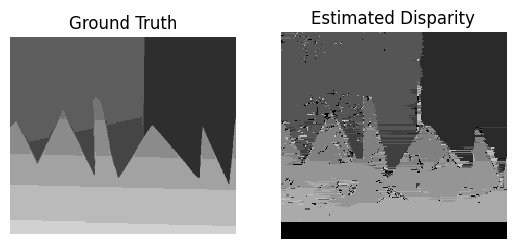

Procesing scanline  174


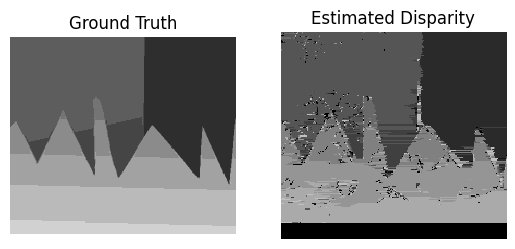

Procesing scanline  175


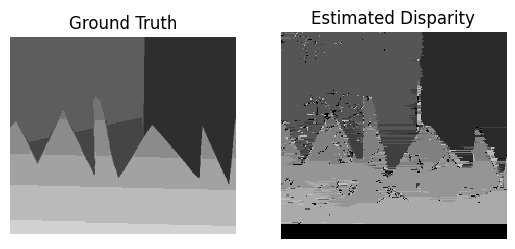

Procesing scanline  176


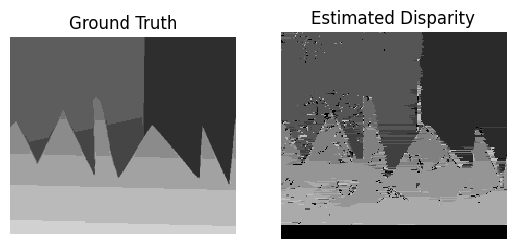

Procesing scanline  177


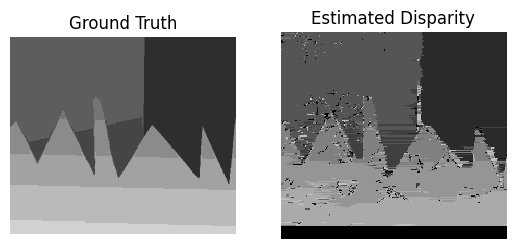

Procesing scanline  178


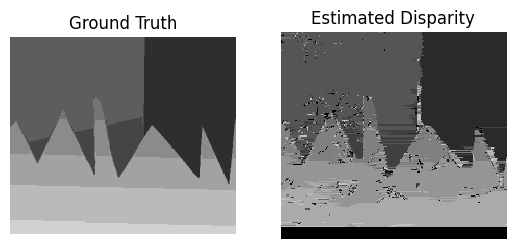

Procesing scanline  179


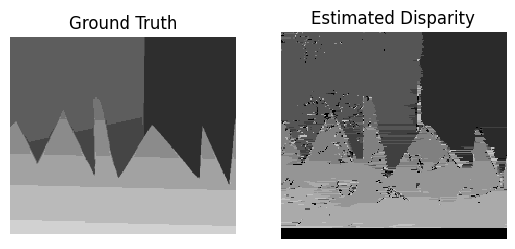

Procesing scanline  180


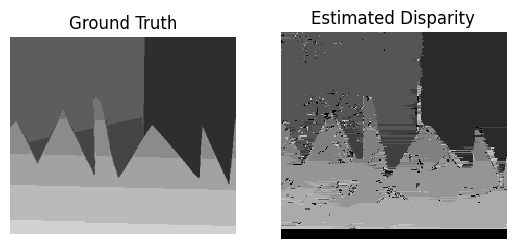

Procesing scanline  181


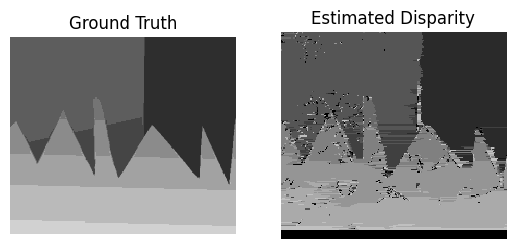

Procesing scanline  182


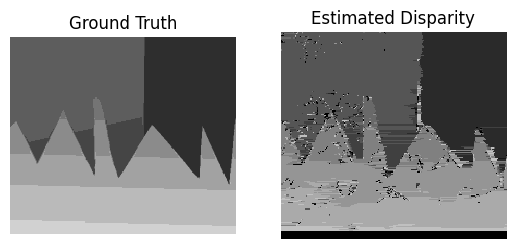

Procesing scanline  183


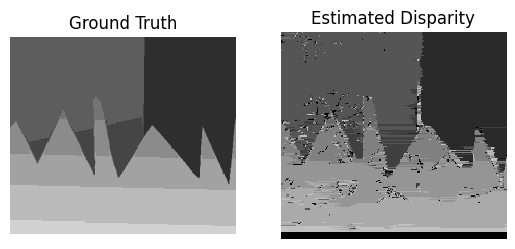

Procesing scanline  184


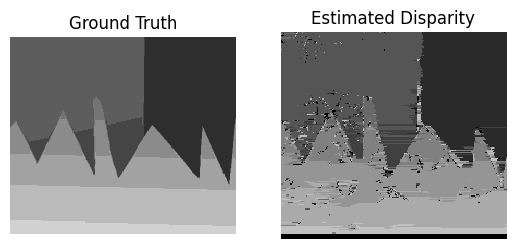

Procesing scanline  185


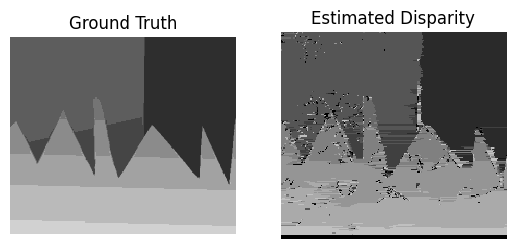

Procesing scanline  186


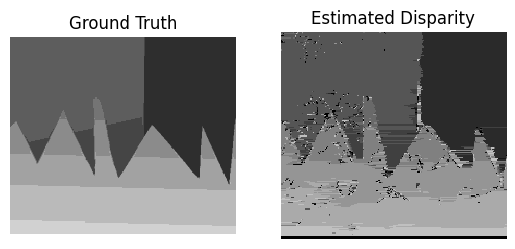

Procesing scanline  187


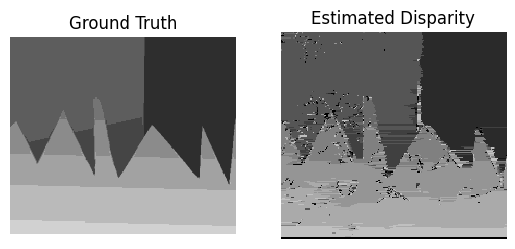

Procesing scanline  188


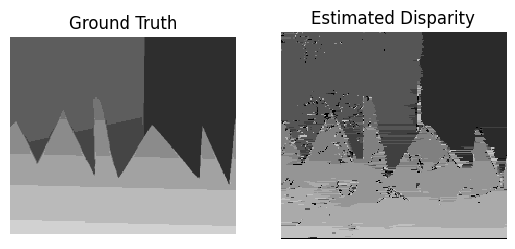

Procesing scanline  189


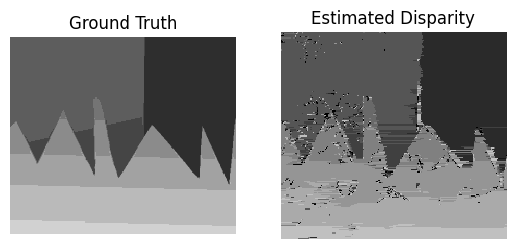

In [23]:
# figure out size of image
imY = len(im1)
imX = len(im1[0])

# define maximum disparity 
maxDisp = 10

# set up pairwiseCosts - we will define a fixed cost of alpha for changing
# disparity or zero cost for staying the same
alpha = 1
pairwiseCosts = alpha*np.ones([maxDisp,maxDisp])-alpha*np.eye(maxDisp)

# initialize the disparity map that we will estimate
estDisp = np.zeros([imY,imX-maxDisp])

# define standard deviation of noise
noiseSD = 6

# display ground truth and estimated disparity
plt.close('all')
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
ax1.axis('off')
ax1.set_title('Ground Truth')
ax2.axis('off')
plt.show()

# run through each line of image
for cY in range(imY):
    print('Procesing scanline ',cY)
    
    # define unary costs - we will not use the last few columns of the
    # image as the disparity might map the pixel outside the valid area of
    # the second image
    unaryCosts = np.zeros([maxDisp,imX-maxDisp])
    
    for cDisp in range(maxDisp):
        cost=np.zeros(imX-maxDisp)
        for cX in range(imX-maxDisp):
            pass
            #TODO - calculate cost for this disparity. This is the 
            #negative log likelihood, where the likelihood is a Gaussian
            #with a mean of the value (i.e. intensity) at the offset pixel 
            #in image2 and a standard deviation of "noiseSD". 
            mean_val = im2[cY, cX + cDisp]
            intensity = im1[cY, cX]   
            cost[cX] = -np.log(np.exp(-((intensity - mean_val)**2) / (2 * noiseSD**2)) / (np.sqrt(2 * np.pi) * noiseSD))
        
        # TODO store this cost in the unaryCosts matrix
        unaryCosts[cDisp, : ] = cost
            
    # TODO uncomment the line below and call the function that you wrote in the previous section (copy it
    # into the cell above)
    
    estDisp[cY,:] = np.transpose(dynamicProgram(unaryCosts,pairwiseCosts))

    # display solution so far
    f, (ax1, ax2) = plt.subplots(1, 2)
    #ax1.clear()
    ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
    ax1.axis('off')
    ax1.set_title('Ground Truth')
    #ax2.clear()
    ax2.imshow(estDisp, vmin=0,vmax=12, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
    ax2.axis('off')
    ax2.set_title('Estimated Disparity')
    plt.show()
    
    
    
# TODO - investigate how different values of alpha and noiseSD affect the results

# TODO (optional) - rewrite the the "dynamicProgram" in the "dynamicProgramVec" function to make it more efficient. 
# Check the improvements by timining the function calls.

# TODO (optional) - you should be able to rewrite this (calculating unary costs) with fewer loops once you have
#the general idea so that it runs faster. Again you can check the speed improvements by timing them.

# TODO (optional)- adapt the algorithm so that it makes use of colour information